Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Splitting training data
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=.80, test_size=.20, stratify=train['status_group'], random_state=256)
print(train.shape, val.shape, test.shape)

(47520, 41) (11880, 41) (14358, 40)


In [0]:
# drop = ['id', 'amount_tsh', 'wpt_name', 'num_private', 'region_code', 'district_code', 'recorded_by', 'scheme_name', 'extraction_type', 'extraction_type_class', 'management_group', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group', 'status_group']
# onehot = ['basin', 'region', 'payment', 'water_quality', 'quantity']
# rest = ['date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'subvillage', 'lga', 'ward', 'population', 'public_meeting', 'scheme_management', 'permit', 'construction_year', 'extraction_type_group', 'management', 'payment_type', 'waterpoint_type', 'source',]

""" RANGLE FUNCTION """
def wrangle(dataframe):
  dataframe = dataframe.copy()

  # Dropping columns
  columns_to_drop = ['id', 'amount_tsh', 'wpt_name', 'num_private', 'region_code', 'recorded_by', 'scheme_name', 'extraction_type', 'extraction_type_class', 'management_group', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group']
  dataframe = dataframe.drop(columns=columns_to_drop, axis=1)

  # Converting to datetime
  dataframe['date_recorded'] = pd.to_datetime(dataframe['date_recorded'], infer_datetime_format=True)

  # Replacing columns with alot of 0's
  dataframe['gps_height'] = dataframe['gps_height'].replace(0, np.nan)
  dataframe['longitude'] = dataframe['longitude'].replace(0, np.nan)
  dataframe['latitude'] = dataframe['latitude'].replace(0, np.nan)
  dataframe['population'] = dataframe['population'].replace(0, np.nan)
  dataframe['construction_year'] = dataframe['construction_year'].replace(0, np.nan)

  # Encoding Booleans
  dataframe['public_meeting'] = dataframe['public_meeting'].replace({True: 1, False: -1, np.nan: 0})
  dataframe['permit'] = dataframe['permit'].replace({True: 1, False: -1, np.nan: 0})

  # Feature engineering
  dataframe['year_recorded'] = dataframe['date_recorded'].dt.year
  dataframe['years'] = dataframe['year_recorded'] - dataframe['construction_year']
  dataframe['years_MISSING'] = dataframe['years'].isnull()
  dataframe['date_recorded'] = pd.to_datetime(dataframe['date_recorded'], infer_datetime_format=True).astype(int)/ 10**9
  

  return dataframe

In [4]:
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import numpy as np

train_wrangled = wrangle(train)
val_wrangled = wrangle(val)
test_wrangled = wrangle(test)

""" ONE HOT ENCODING """

cols = ['basin', 'region', 'payment', 'water_quality', 'quantity']
subset = train_wrangled[cols]
subset.head(3)

""" TRAINING """
# Encoding columns
onehot_encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = onehot_encoder.fit_transform(subset)

# Concatinating dataframes
final_train = pd.concat([train_wrangled, encoded], axis=1)

# Dropping old columns
final_train = final_train.drop(columns=cols, axis=1)
final_train = final_train.drop(columns='status_group', axis=1)

""" VALIDATION """
subset = val_wrangled[cols]
encoded = onehot_encoder.transform(subset)
final_val = pd.concat([val_wrangled, encoded], axis=1)
final_val = final_val.drop(columns=cols, axis=1)
final_val = final_val.drop(columns='status_group', axis=1)

""" TESTING """
subset = test_wrangled[cols]
encoded = onehot_encoder.transform(subset)
final_test = pd.concat([test_wrangled, encoded], axis=1)
final_test = final_test.drop(columns=cols, axis=1)
final_test.shape

(14358, 73)

In [0]:
""" CONCAT VAL AND TRAIN """
ultimate_X = pd.concat([final_train, final_val], axis=0)
ultimate_y = pd.concat([train['status_group'], val['status_group']], axis=0)


##Final Model

In [12]:
from scipy.stats import randint, uniform
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV



pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=121)
)

param_distributions = {
    'simpleimputer__strategy': ['mean'], 
    'randomforestclassifier__max_depth': [20],
    'randomforestclassifier__min_samples_leaf':[2],
    'randomforestclassifier__n_estimators': [40],  
    'randomforestclassifier__max_features': uniform(0, 1), 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=15, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(ultimate_X, ultimate_y);

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.6min


In [13]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy', search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.2453593045941871, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__n_estimators': 40, 'simpleimputer__strategy': 'mean'}
Cross-validation accuracy 0.806969696969697


In [0]:
y_pred = search.predict(final_test)

submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('Cooper_Vos_Submission_ripx3', index=False)

## Confusion Matrix

In [9]:
""" PIPELINE """
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(random_state=300,
                           n_estimators=100,
                           min_samples_leaf=2
                           )
)

pipeline.fit(final_train, train['status_group'])
print('Validation Accuracy', pipeline.score(final_val, val['status_group']))

Validation Accuracy 0.8106902356902357


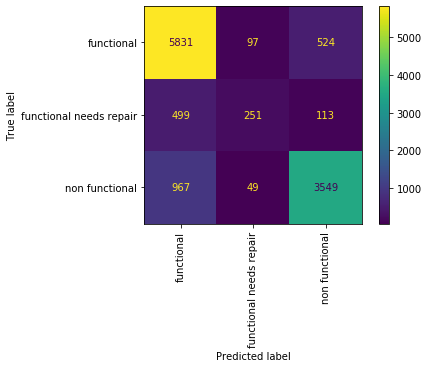

In [10]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, final_val, val['status_group'], values_format='.0f', xticks_rotation='vertical');